# Initiation & Functions

In [1]:
# import

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import math
import random

import sys

In [220]:
# Membuat fungsi untuk menilai dampak policy terhadap lingkungan
# Semakin nilai fungsi ini mendekati 0 maka semuanya akan semakin bagus
def g(P, X):
    i = 0
    sigma_sx = 0
    sigma_s = 0
    while i < len(P):
        sigma_sx = sigma_sx + P[i][0]*X[i]
        sigma_s = sigma_s + P[i][0]
        i += 1
    return 1-(sigma_sx/sigma_s)



# Membuat fungsi payoff untuk action yang mungkin di timestep berikutnya
# untuk pemain-i.
# player adalah pemain ke berapa yang sedang dicari payoff functionnya (ingat indeks python)
# action adalah aksi (berapa persen (dalam desimal) investasi) pemain-i untuk timestep berikutnya
# P adalah matriks pemain. Nanti diambil aksi pemain lain selain pemain i
# X adalah matriks payoff
# Fungsi ini nanti digunakan untuk memilih max_payoff{0, 1, -b/2a} dengan syarat
# 0 <= -b/2a <= 1
def payoff(player, action, P, X):
    
    sigma_min_i = 0
    i = 0
    while i < len(P):
        if i != player:
            sigma_min_i = sigma_min_i + X[i]
        i += 1
    
    return (1 + alpha*(action+sigma_min_i)/N)*P[player][0]*P[player][1]*action + (1 - beta*(action+sigma_min_i)/N)*P[player][0]*P[player][2]*(1-action)



# membuat fungsi untuk menghitung -b/2a
# nanti jika 0 < -b/2a < 1 maka jadi calon titik optimum
# player adalah pemain ke berapa yang sedang dicari -b/2a nya
# P adalah matriks pemain. Nanti diambil aksi pemain lain selain pemain i
# X adalah matriks payoff
def min_b2a(player, P, X):
    
    sigma_min_i = 0
    i = 0
    while i < len(P):
        if i != player:
            sigma_min_i = sigma_min_i + X[i]
        i += 1
    
    return -(P[player][1]*P[player][0] - P[player][2]*P[player][0] + (alpha*P[player][1]*P[player][0]*sigma_min_i + beta*P[player][2]*P[player][0]*sigma_min_i - beta*P[player][2]*P[player][0])/N)/(2*(alpha*P[player][1]*P[player][0] + beta*P[player][2]*P[player][0])/N)



# mencari yang maksimal itu 0, 1, atau -b/2a
def x_optimum(player, P, X):
    
    # action
    a = 0
    b = min_b2a(player, P, X)
    #print(b)
    c = 1
    
    maksimal = -1
    
    # cari maksimal
    
    # saat 0 < b < 1 -> berarti b masuk
    if 0 < b < 1:
        if payoff(player, a, P, X) >= payoff(player, b, P, X) and payoff(player, a, P, X) >= payoff(player, c, P, X):
            maksimal = a
        if payoff(player, b, P, X) >= payoff(player, a, P, X) and payoff(player, b, P, X) >= payoff(player, c, P, X):
            maksimal = b
        if payoff(player, c, P, X) >= payoff(player, a, P, X) and payoff(player, c, P, X) >= payoff(player, b, P, X):
            maksimal = c
    else:
        if payoff(player, a, P, X) >= payoff(player, c, P, X):
            maksimal = a
        else:
            maksimal = c
    
    return maksimal

# Game Initiation

In [221]:
# mendefinisikan permainan

# pemain
N = 4                                 # N adalah banyak pemain

P = np.zeros((N,3))                   # P adalah state pemain
P = P.tolist()                        # ini tolist agar bentuknya pake list saja karena mudah

# inisiasi matriks P(S, A, B) dengan S adalah aset, A persentase keuntungan green investment, B persentase keuntungan biasa
# untuk random S, A, B ini nanti disesuaikan range nya
# dari ini yang penting kita asumsikan A << B menurut status quo

# randomisasi untuk update nilai A dan B
koefisien_random_A = 0.01
koefisien_random_B = 0.01


# state aksi yang dipilih di awal
X = []                                # X adalah matriks yang berisi aksi setiap pemain, isinya 0 <= xi <= 1

random.seed(0)                        # seed aja kalau main random inisiasi

# mengisi matriks permainan P
# dan matriks aksi X
i = 0
while i < N:
    P[i][0] = random.uniform(10, 20)
    hore = random.uniform(0, 0.005) # dalam persentase -> keunntungan ekonomi hijau
    P[i][1] = hore                # keuntungan ekonommi hijau
    P[i][2] = 1000*hore        # dalam persentase. Asumsi penting: P[i][2] >> P[i][1] 
    
    # Matriks aksi dengan berbagai initial conditions
    
    X.append(random.uniform(0,1))
    #X.append(0)
    #X.append(1)
    
    i += 1

# inisiasi alpha dan beta sebagai faktor koreksi insentif dan pajak
# untuk nilainya nanti kita kuli satu satu dan jika N(+1) pemain nanti
# ditentukan melalui payoff untuk pemerintah
alpha = 1       # koefisien insentif ekonomi hijau
beta  = 2       # koefisien pajak ekonomi tidak hijau

# memasukkan time_step maksimal untuk penelitian
# nanti time mulai dari 1 .. time_step karena untuk 0 udah dipake di list E
# Ini BANYAKNYA RONDE PERMAINAN
max_round = 10

# Membuat list penampung, E
# list E dan F berisi nilai emisi dari state awal permainan sampai akhir
# semakin nilai elemen list E mendekati 0 maka semakin kecil emisi ke lingkungan
# dari formulanya, 0 <= g(P) <= 1
# memasukkan nilai E dan F di kondisi awal
E = []
E.append(g(P, X))

# Game

In [222]:
# Keperluan plotting pemain
P_plot = np.zeros((N,max_round+1))                   # P_plot adalah container yang berisi uang pemain per time step
P_plot = P_plot.tolist()

# Plot Actions -> aksi pemain i pada waktu j
plot_actions = np.zeros((N, max_round+1))
plot_actions = plot_actions.tolist()

i = 0
while i < N:
    P_plot[i][0] = P[i][0]
    plot_actions[i][0] = X[i]
    i += 1

    
time_control = 1

# PERMAINAN LOOP
while time_control <= max_round:
    # update nilai X
    i = 0
    while i < N:
        X[i] = x_optimum(i, P, X)
        i += 1
    
    # update matrix P berdasarkan X untuk tiap round
    i = 0
    while i < N:
        
        # keuntungan total (uang total enaknya)
        P[i][0] = P[i][0] + payoff(i, X[i], P, X) # ini pakai payoff instead of P[i][0] += x[i]*A[i] + (1-x[i])*B[i]
                                                  # karena kalau pakai P[i][0] += x[i]*A[i] + (1-x[i])*B[i] artinya
                                                  # pajak dan insentif belum masuk ke perhitungan keuntungan
        
        # randomisasi persentase keuntungan dari ekonomi hijau dan non hijau
        P[i][1] = P[i][1] + random.uniform(-koefisien_random_A, koefisien_random_A)*P[i][1]      # dalam persentase
        P[i][2] = P[i][2] + random.uniform(-koefisien_random_B, koefisien_random_B)*P[i][2]      # dalam persentase
        
        # update P_plot
        P_plot[i][time_control] = P[i][0]
        # update plot action
        plot_actions[i][time_control] = X[i]
        
        i += 1
        
    # Melihat kondisi lingkungan
    E.append(g(P, X))
    
    time_control += 1

# Plotting for Analysis

In [223]:
# making the space
sumbu_x = []
i = 0
while i <= max_round:
    sumbu_x.append(i)
    i += 1

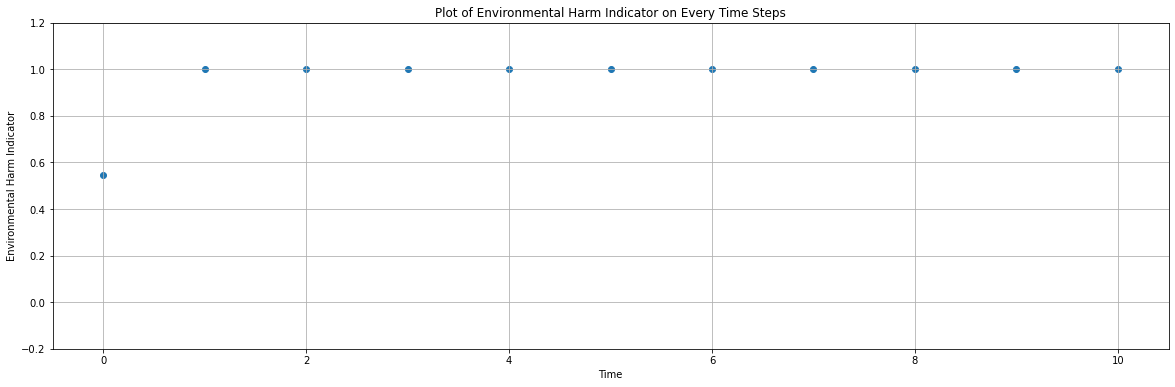

In [224]:
# plot kondisi lingkungan
plt.figure(figsize=(20,6))
plt.scatter(sumbu_x, E)
plt.title("Plot of Environmental Harm Indicator on Every Time Steps")
plt.xlabel("Time")
plt.ylabel("Environmental Harm Indicator")
plt.grid(True)
plt.ylim(-0.2, 1.2)
plt.show()

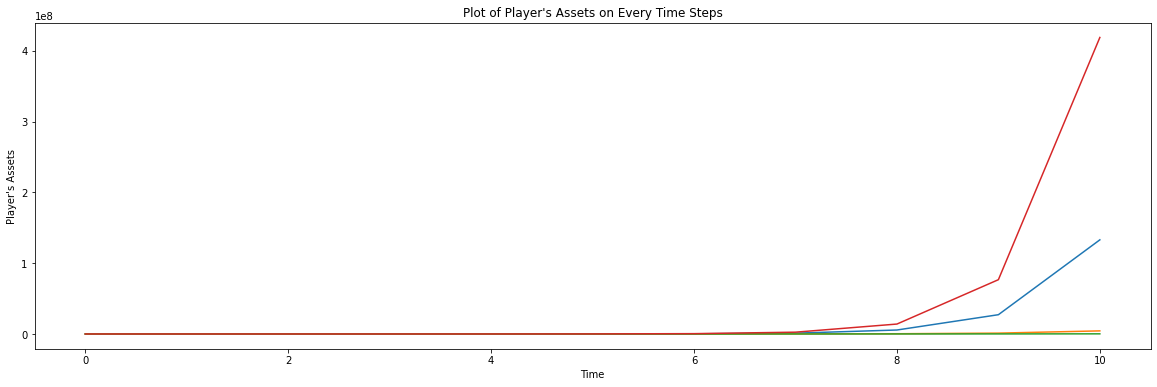

In [225]:
# Plotting Kondisi Setiap Pemain

plt.figure(figsize=(20,6))
i = 0
while i < N:
    plt.plot(sumbu_x, P_plot[i])
    i += 1
plt.title("Plot of Player's Assets on Every Time Steps")
plt.xlabel("Time")
plt.ylabel("Player's Assets")

plt.show()

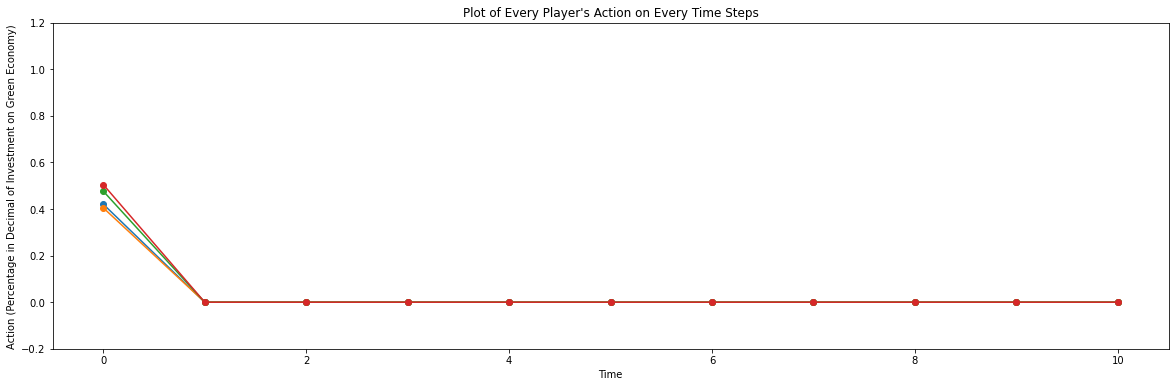

In [226]:
# Plotting Actions per Rounds

plt.figure(figsize=(20,6))
i = 0
while i < N:
    plt.plot(sumbu_x, plot_actions[i], marker = 'o')
    i += 1
plt.title("Plot of Every Player's Action on Every Time Steps")
plt.xlabel("Time")
plt.ylim(-0.2, 1.2)
plt.ylabel("Action (Percentage in Decimal of Investment on Green Economy)")

plt.show()

In [227]:
# Checking Numerical Nash
dummy = np.array(plot_actions).T.tolist() # transpose
#print("Player actions: \n", dummy, "\n")
nash = False
i = 0
while i < len(dummy)-1 and nash == False:
    if dummy[i] == dummy[i + 1]:
        nash = True
    i = i + 1
print("Nash exist: ", nash)

Nash exist:  True
